smart_hans_07252022_154259_11_395-432_08_mgy_.csv
smart_hans_07252022_154619_12_431-469_08_mgy_.csv
smart_hans_07252022_155048_13_482-523_08_mny_.csv
smart_hans_07252022_155230_11_402-439_08_mgy_.csv
smart_hans_07312022_160010_5_109-124_08_mny_x.csv
smart_hans_07312022_161226_7_250-280_08_mgy_.csv
smart_hans_07312022_161925_10_313-339_08_mny_.csv
smart_hans_07312022_162132_5_146-170_08_mny_.csv
smart_hans_07312022_162305_9_246-269_08_mny_.csv
smart_hans_07312022_162745_8_272-303_08_mgy_.csv
smart_hans_07312022_164319_11_363-393_08_mny_.csv
smart_hans_07312022_164533_9_305-333_08_mgy_.csv
smart_hans_07312022_164702_5_181-209_08_mgy_.csv
smart_hans_07312022_164838_8_276-305_08_mgy_klatschen_8_ende.csv
smart_hans_07312022_165851_12_402-433_08_mgy_.csv
smart_hans_07312022_170052_6_215-244_08_mgy_.csv
smart_hans_07312022_170216_4_149-178_08_mgy_furz_lachen_am_ende.csv
smart_hans_07312022_170549_7_197-222_08_mnn_.csv
smart_hans_07312022_171246_5_174-198_08_mnn_.csv
smart_hans_07312022_171406

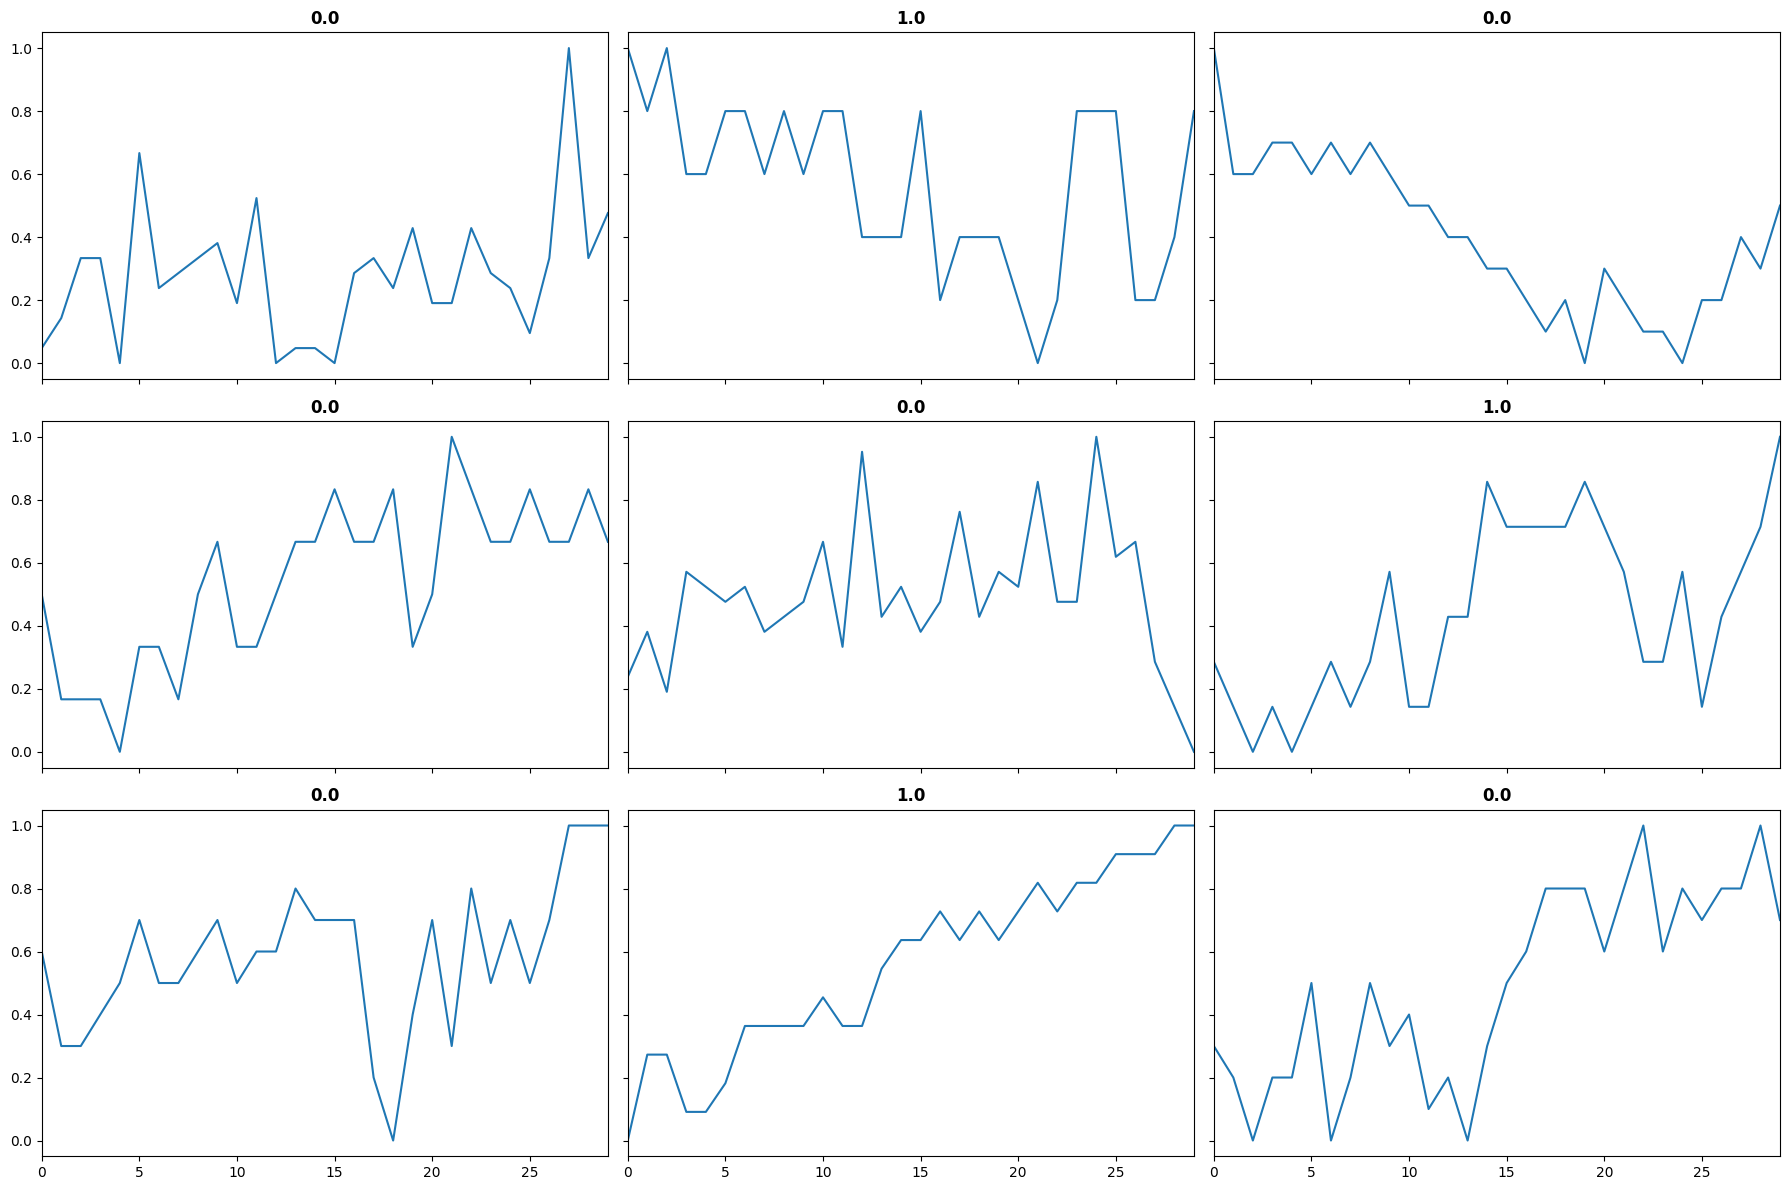

In [36]:
from tsai.all import *
import pandas as pd
from datenverarbeitung.dataloader import dataloader
import datetime
CUDA_LAUNCH_BLOCKING=1



num_scenario = 4

nr_taps = 1

tap_size = 30

move_by = -12

learning_cycles = 6

model_to_use = "InceptionTime"

features_to_learn_with = ["chin_y"]
feature_list_string = '_'.join(features_to_learn_with)

models_folder = "models"
plots_folder = "vis/plots"
save_name = "scenario_{}_{}".format(num_scenario, model_to_use)

dl = dataloader(scenario= num_scenario, path="C:/Users/adi/Nextcloud/smart_hans/AP2/Daten/zum_sichten/laeuft", nr_taps=nr_taps, move_window_by=move_by, tap_size=tap_size, feature_list=features_to_learn_with)
train, test, df= dl.train, dl.test, dl.df

X_test, y_test = df2xy(test, target_col='target')
X_train, y_train = df2xy(train, target_col='target')

X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

dls = TSDataLoaders.from_dsets(dsets.train, dsets.valid,  num_workers=0)

print(df.shape)
dls.show_batch(sharey=True)

In [37]:

scenario_name_stage0 = save_name+"_nr_taps_{}_features_{}".format(str(nr_taps), feature_list_string)+"_stage0"
model = InceptionTime(dls.vars, dls.c, tap_size)
learn = Learner(dls, model, metrics=accuracy, lr=0.001)
learn.save(scenario_name_stage0)

Path('models/scenario_4_InceptionTime_nr_taps_1_features_chin_y_stage0.pth')

In [38]:
learn.load(scenario_name_stage0)
#learn.lr_find(start_lr=1e-07, end_lr=10, num_it=100, stop_div=True, show_plot=True)


In [39]:
learn.lr = 0.001
#learn.fine_tune(1)

In [40]:
scenario_name_stage1 = scenario_name_stage0.replace("0","1")

learn.fit_one_cycle(learning_cycles,lr_max=1e-4)

learn.save(scenario_name_stage1)
#learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

epoch,train_loss,valid_loss,accuracy,time
0,0.711556,0.691388,0.572917,00:00
1,0.708136,0.690602,0.572917,00:00
2,0.699128,0.690470,0.572917,00:00
3,0.688300,0.690760,0.593750,00:00
4,0.683256,0.691138,0.572917,00:00
5,0.676019,0.691588,0.572917,00:00


Path('models/scenario_4_InceptionTime_nr_taps_1_features_chin_y_stage1.pth')

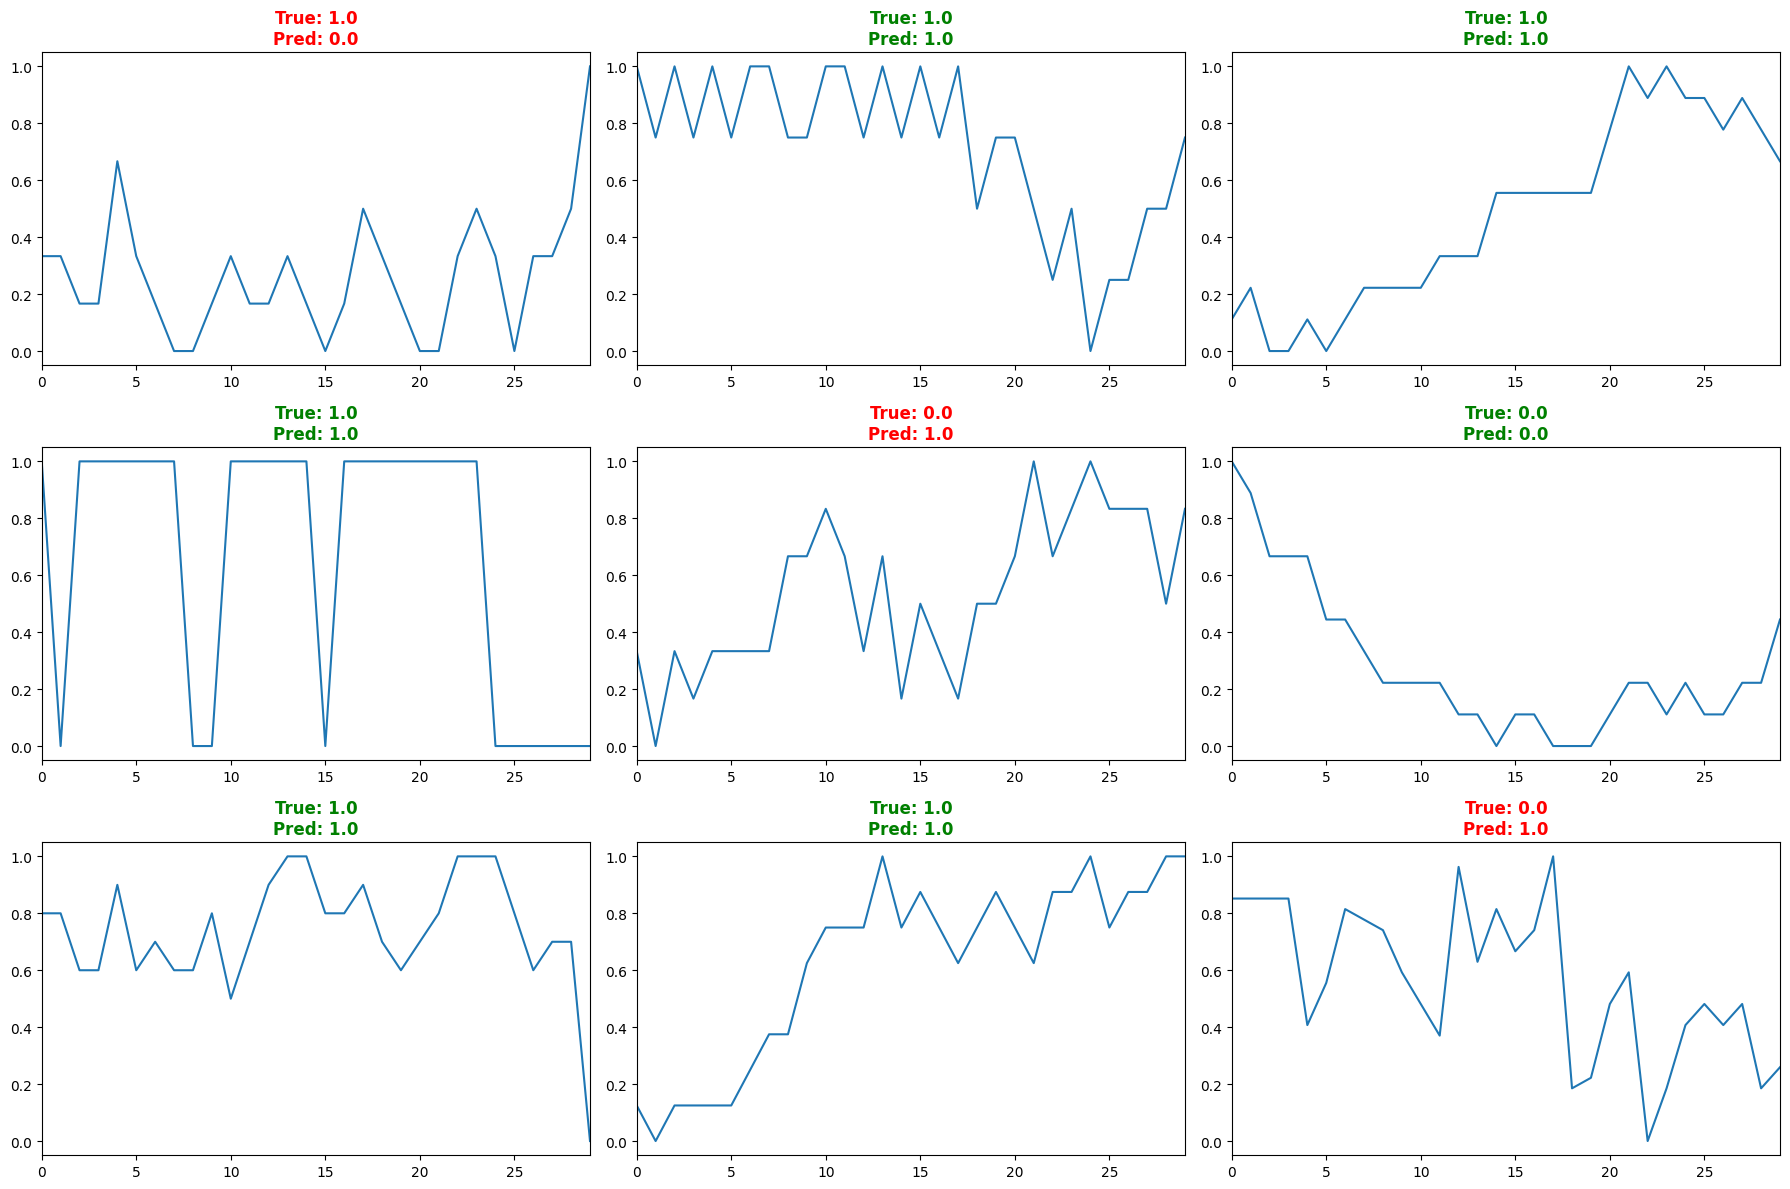

In [41]:
learn.show_results()

not enough values to plot a chart


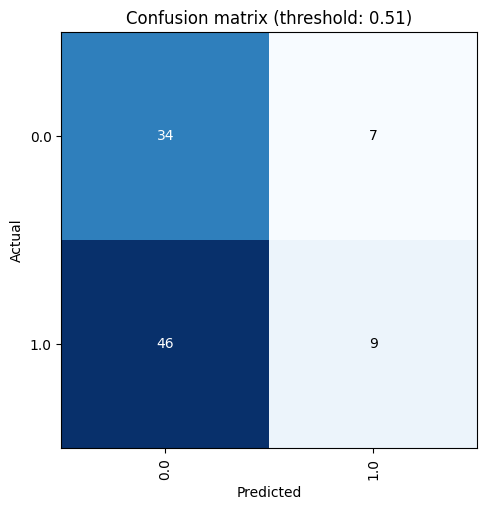

In [42]:
learn.recorder.plot_metrics()
learn.plot_confusion_matrix(thr=0.51)
feature_list_string = '_'.join(features_to_learn_with)
current_time= datetime.datetime.now().strftime('%d%m%Y_%H%M%S')
plot_name = plots_folder+"/confusion_matrix_"+save_name+"_nrtaps_{}_features_{}_learning_cycles_{}_{}.png".format(str(nr_taps),feature_list_string,learning_cycles, current_time)

#plt.savefig(plot_name, ext='png', bbox_inches="tight")

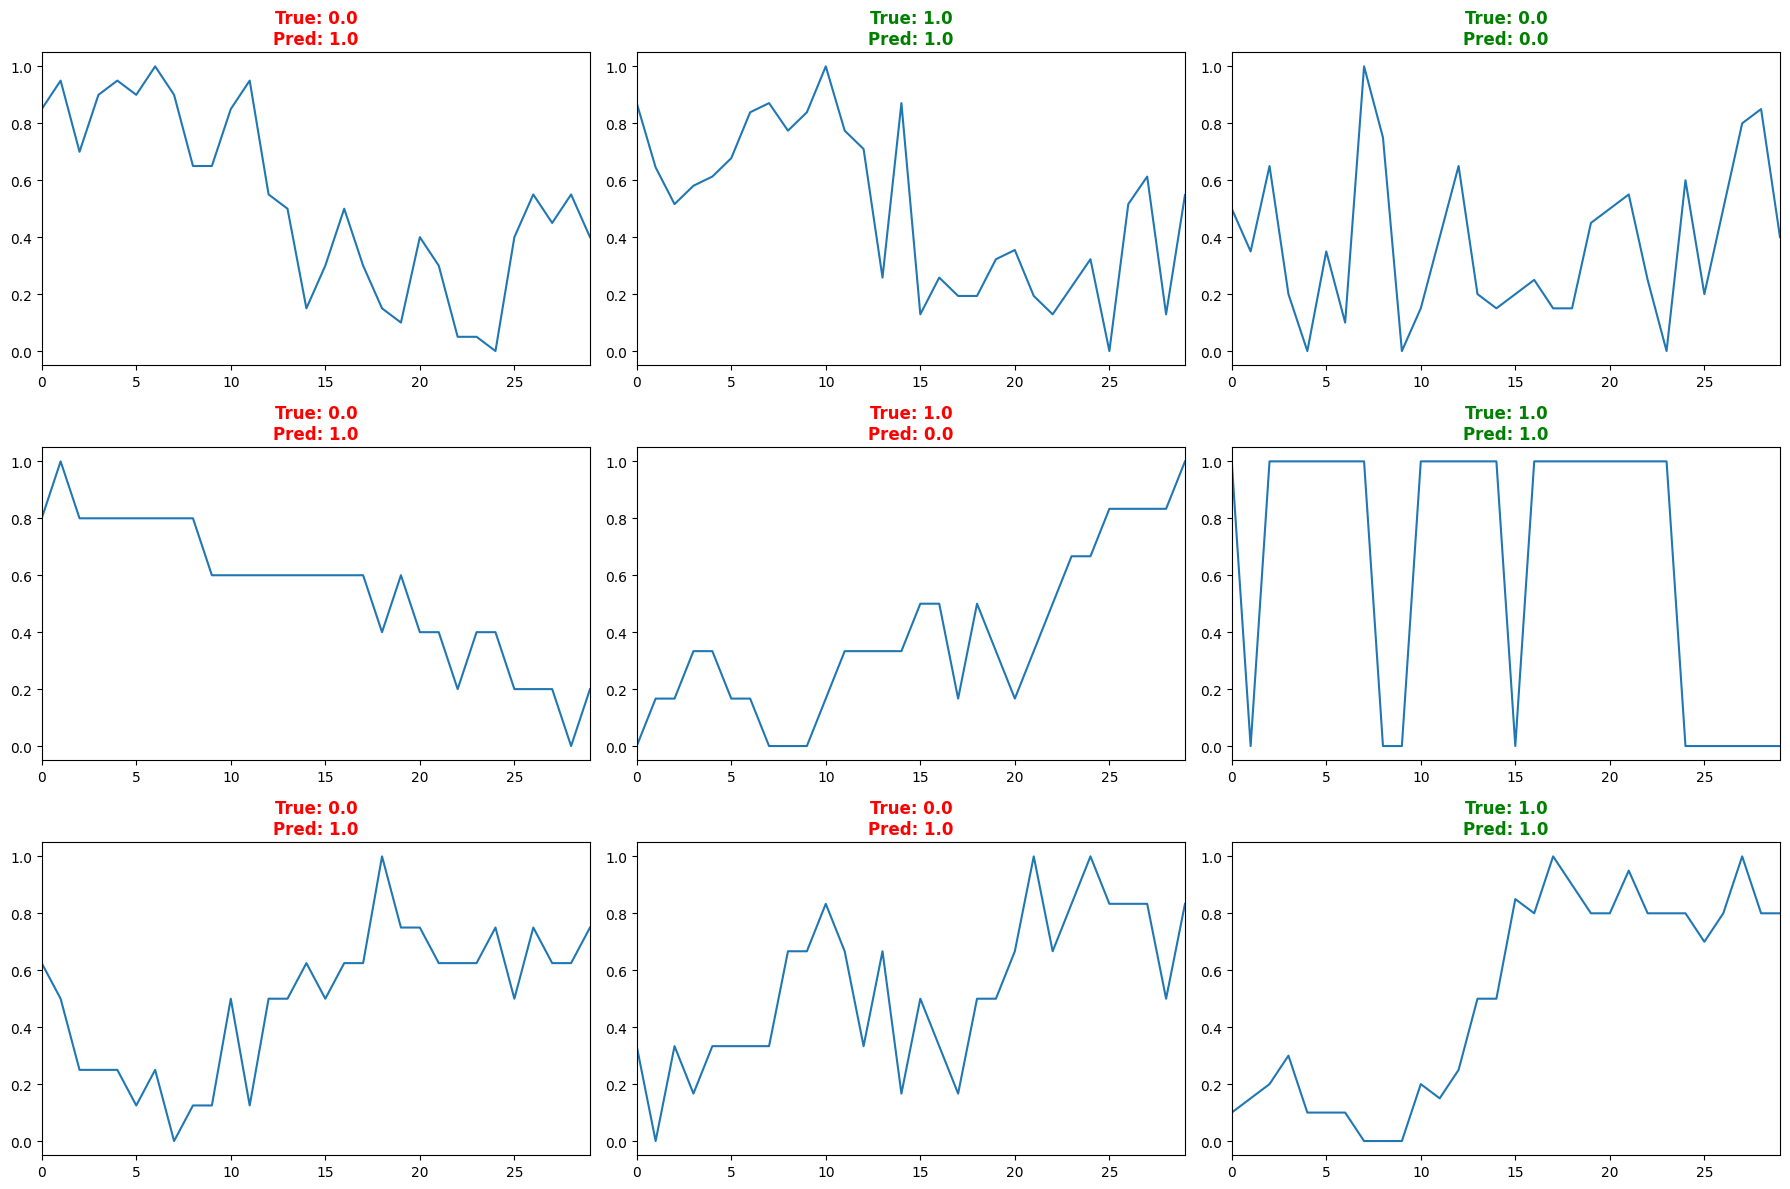

In [43]:
learn.show_results()

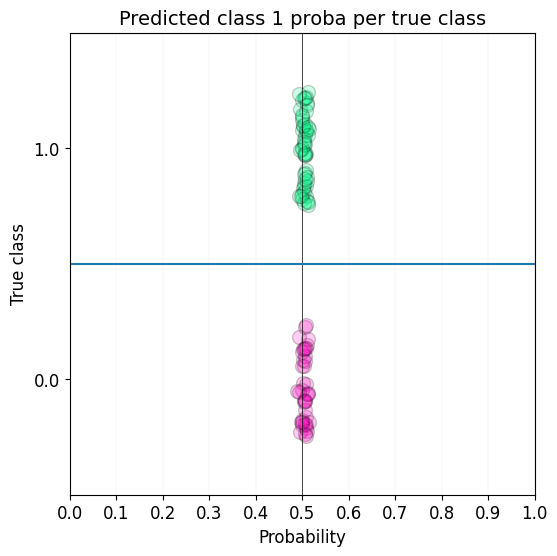

In [44]:
learn.show_probas()
#was sagt probability aus? accuracy vs probability?